In [1]:
!nvidia-smi

Sat Jan 22 06:52:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#   Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras.datasets import cifar100
(X_train, Y_train), (X_valid, Y_valid) = cifar100.load_data()

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.15)
print('X_train shape', X_train.shape)
print('X_valid shape', X_valid.shape)
print('X_test shape', X_test.shape)

169017344/169001437 [==============================] - 3s 0us/step
X_train shape (42500, 32, 32, 3)
X_valid shape (10000, 32, 32, 3)
X_test shape (7500, 32, 32, 3)


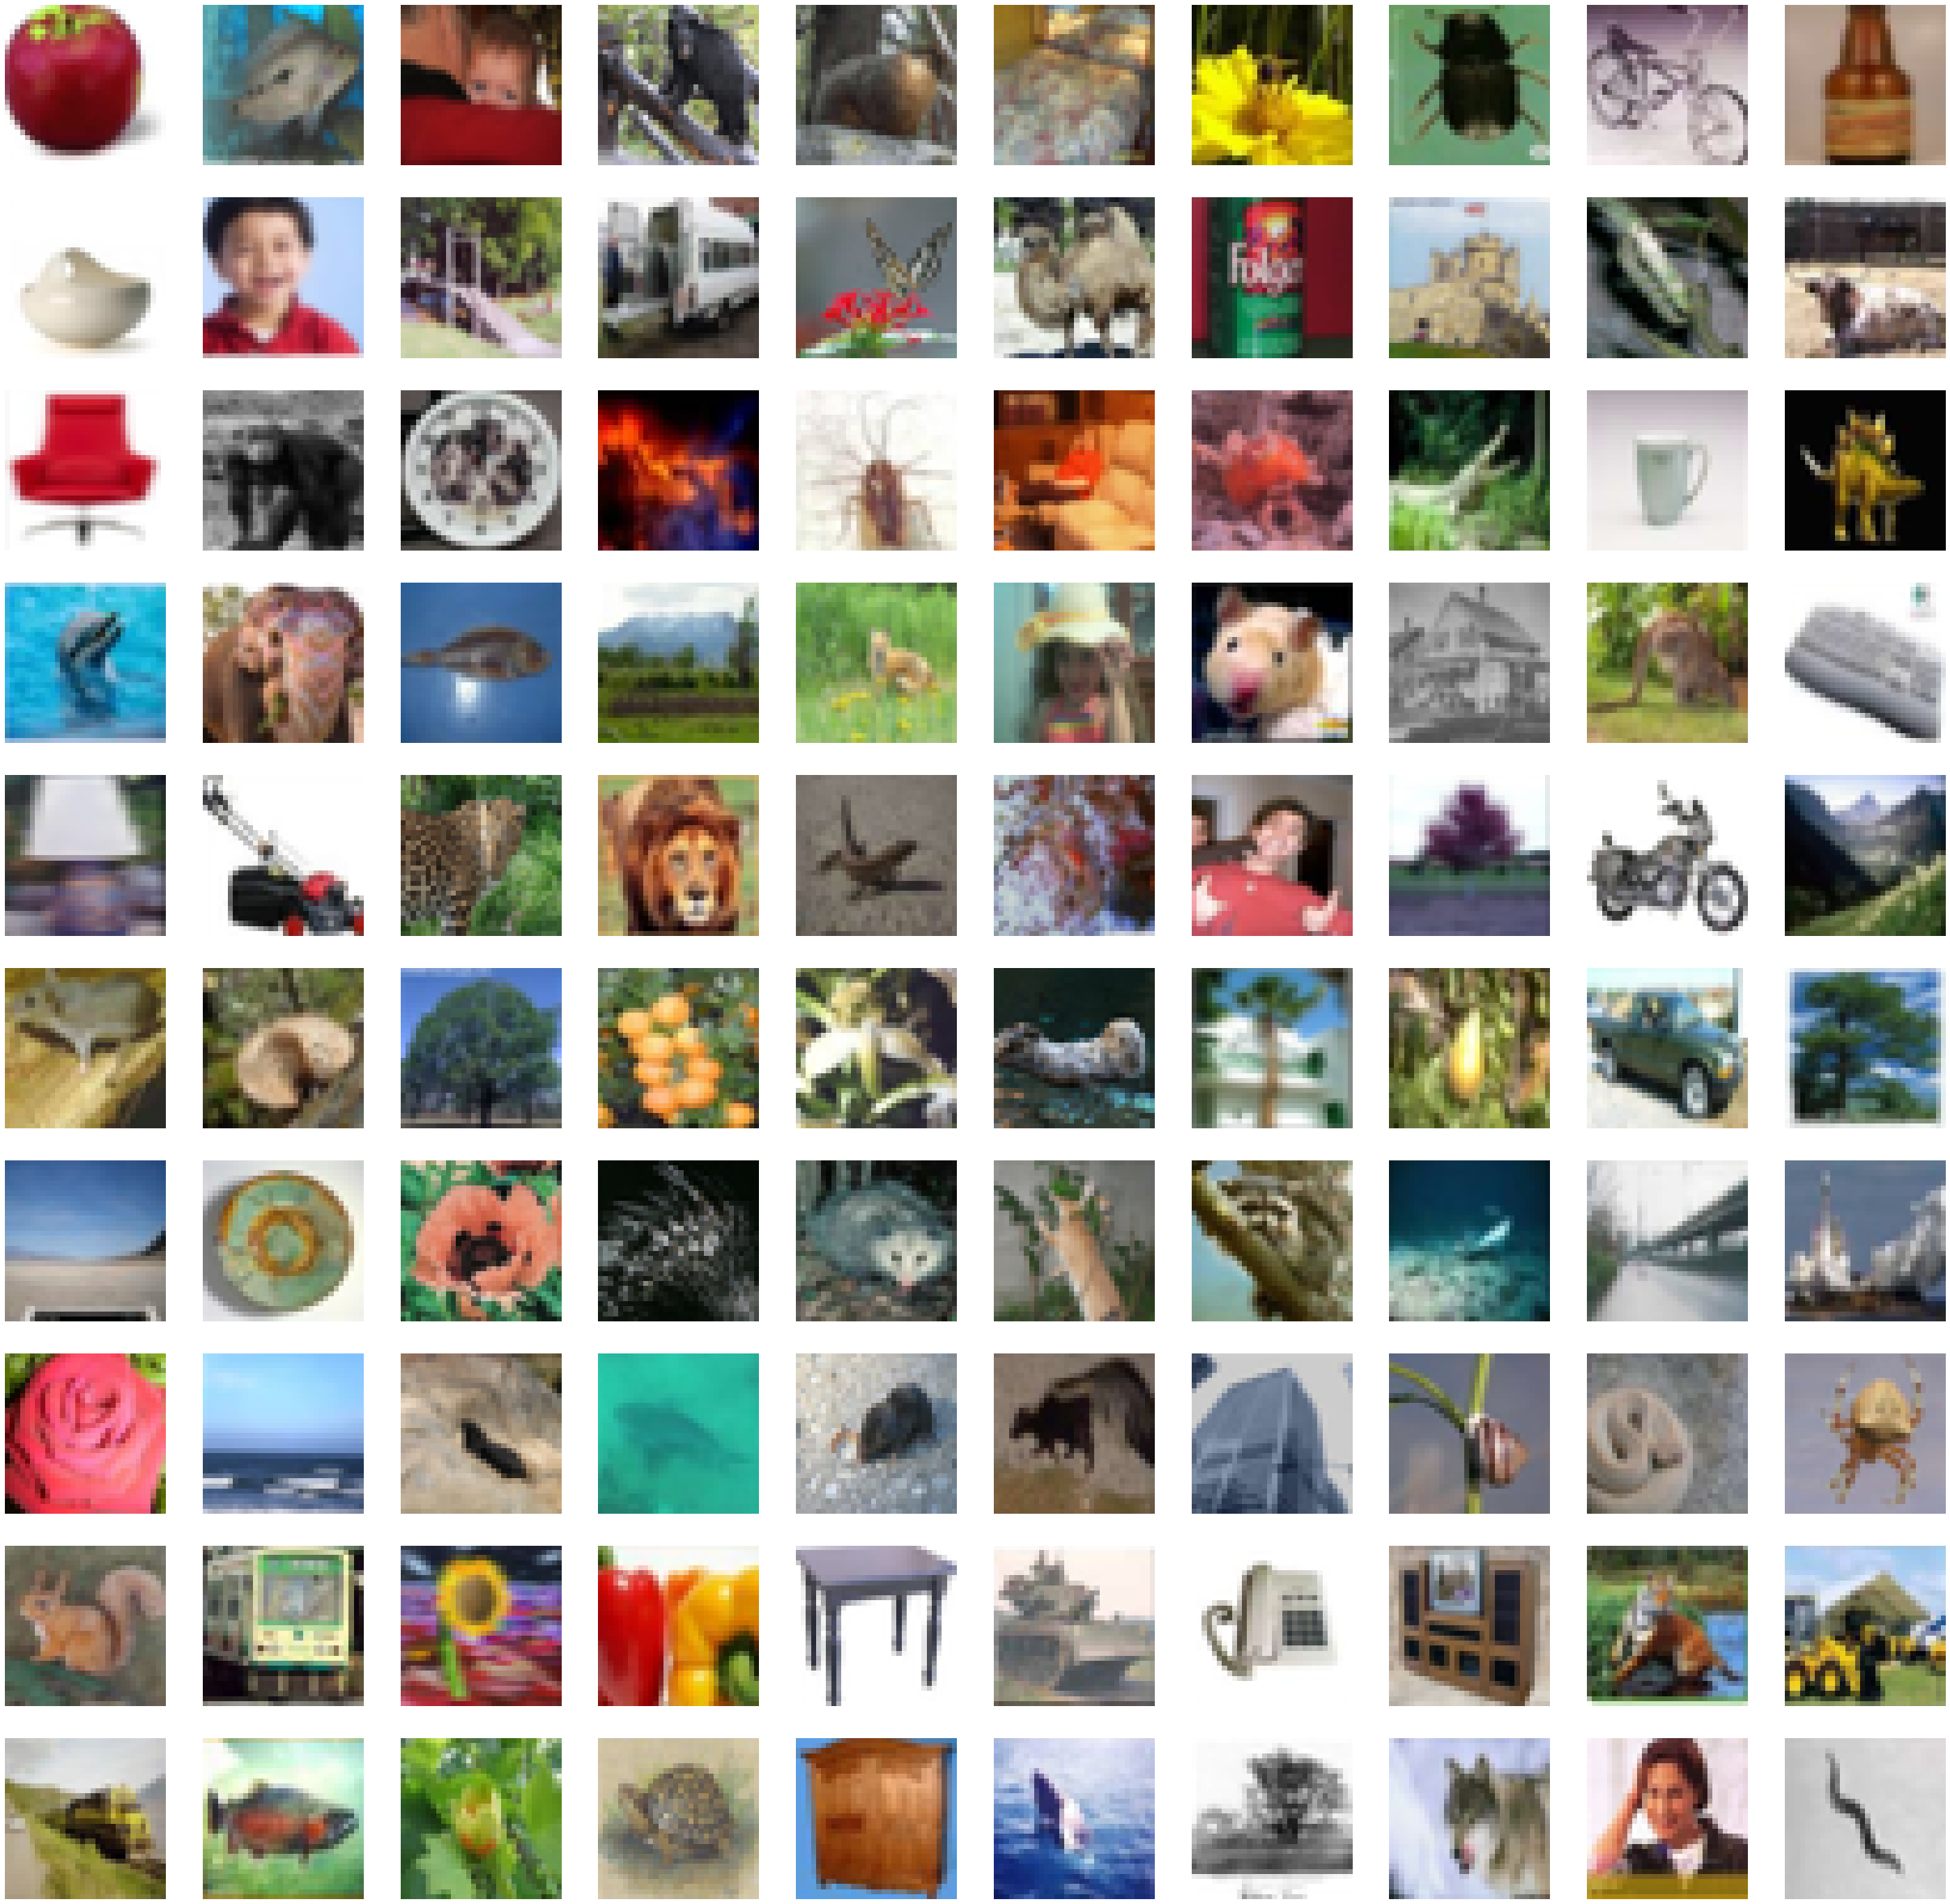

In [6]:
fig = plt.figure(figsize = (50,50))
for index, image in enumerate(X_train[:100]):
    ax = fig.add_subplot(10, 10, index + 1)
    #   Plots 100 class of images
    idx_class = np.where(Y_train == index)[0]
    ax.imshow(X_train[idx_class[0]])
    ax.axis('off')
plt.show()

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D, UpSampling2D, Input, Conv2D
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.models import Model, load_model
from keras.constraints import max_norm

In [8]:
Y_train = np_utils.to_categorical(Y_train, 100)
Y_valid = np_utils.to_categorical(Y_valid, 100)
Y_test = np_utils.to_categorical(Y_test, 100)

In [9]:
batch_size = 32

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [ ]:
data_aug = ImageDataGenerator(preprocessing_function = get_random_eraser(v_l=0, v_h=1, pixel_level=True))

In [ ]:
conv_base = EfficientNetB7(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
#   Image input with target_size = (224, 224)
input_img = Input(shape = (32, 32, 3))
print(input_img.shape)
upsame_img = UpSampling2D(size = (7, 7))(input_img)
print(upsame_img.shape)

#   Convolution layers
fcHead = conv_base(upsame_img)
fcHead = GlobalAveragePooling2D()(fcHead)

#   Neural Network
fcHead = Dense(512, activation = 'swish', kernel_initializer = 'he_uniform')(fcHead)
fcHead = Dropout(.5)(fcHead)
fcHead = BatchNormalization()(fcHead)
preds = Dense(100, activation = "linear")(fcHead)

model = Model(inputs = input_img, outputs = preds)

In [ ]:
for layer in conv_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

## ***Train model 1st***

In [ ]:
opt = Adam(learning_rate = 0.003)
loss_function = CategoricalCrossentropy(from_logits = True)
model.compile(optimizer = opt, loss = loss_function, metrics = 'accuracy')

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#   Callback function
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, factor = 0.5, min_lr = 1e-6)
checkpoint = ModelCheckpoint(filepath = os.path.join(base_path, 'Best_Model.h5'), verbose = 1, save_best_only = True)

In [ ]:
H = model.fit_generator(generator = data_aug.flow(X_train, Y_train, batch_size = batch_size), 
                        epochs = 10, 
                        steps_per_epoch = X_train.shape[0]//batch_size, 
                        validation_data = data_aug.flow(X_valid, Y_valid, batch_size = batch_size), 
                        validation_steps = X_valid.shape[0]//batch_size, 
                        shuffle = True, 
                        callbacks = [early_stop, reduce_lr, checkpoint]) 

In [ ]:
fig = plt.figure(figsize = (12, 5))

(ax1, ax2) = fig.subplots(1, 2)
ax1.plot(H.history['accuracy'], label = 'acc')
ax1.plot(H.history['val_accuracy'], label = 'val_acc')
ax1.set_title('Model Accuracy', fontsize = 15, c = 'g')
ax1.set_ylabel('Accuracy', fontsize = 15)
ax1.set_xlabel('Epoch', fontsize = 15)
ax1.legend(loc = 'lower right', prop = {'size': 15})

ax2.plot(H.history['loss'], label = 'loss')
ax2.plot(H.history['val_loss'], label = 'val_loss')
ax2.set_title('Model Accuracy', fontsize = 15, c = 'g')
ax2.set_ylabel('Loss', fontsize = 15)
ax2.set_xlabel('Epoch', fontsize = 15)
ax2.legend(loc = 'upper right', prop = {'size': 15});

## ***Train model 2nd***

In [ ]:
for layer in conv_base.layers[-50:]:
    layer.trainable = True

In [ ]:
opt = SGD(learning_rate = 0.0001)
loss_function = CategoricalCrossentropy(from_logits = True)
model.compile(optimizer = opt, loss = loss_function, metrics = 'accuracy')

In [ ]:
H2 = model.fit_generator(generator = data_aug.flow(X_train, Y_train, batch_size = batch_size), 
                        epochs = 10, 
                        steps_per_epoch = X_train.shape[0]//batch_size, 
                        validation_data = data_aug.flow(X_valid, Y_valid, batch_size = batch_size), 
                        validation_steps = X_valid.shape[0]//batch_size, 
                        shuffle = True, 
                        callbacks = [early_stop, reduce_lr, checkpoint]) 

In [11]:
#   Load model
model = load_model('/content/drive/MyDrive/CIFAR100 classification/model.h5')

## ***Evaluate model with test set***

In [12]:
score = model.evaluate(X_test, Y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

235/235 [==============================] - 93s 336ms/step - loss: 0.3341 - accuracy: 0.8968
Test loss: 0.3341
Test accuracy: 0.8968
